10.01.2021

### Image Processing in Physics
#### Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss

# Exercise 2: Phase retrieval with Paganin's algorithm

Recover the projected thickness of a teflon plate quantitatively
from its intensity measurement in the near-field. We assume a single material, so we can apply [Paganin's algorithm](https://onlinelibrary.wiley.com/doi/abs/10.1046/j.1365-2818.2002.01010.x).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"

Load projection data from file. It is an X-ray projection image of a $250\,\mathrm{\mu m}$ thick Teflon plate.

In [2]:
proj = np.load("proj.npy")

Look at the data.
* You can see the edge-enhanced borders at the transition from Teflon to air.
* In addition, the absorbing properties of the Teflon plate are visible.
* Note that the background-values are around 1: The intensity given here is given relative to the intensity without the sample (the so-called 'flat-field image') -- it is thus a _relative_ intensity.

<IPython.core.display.Javascript object>


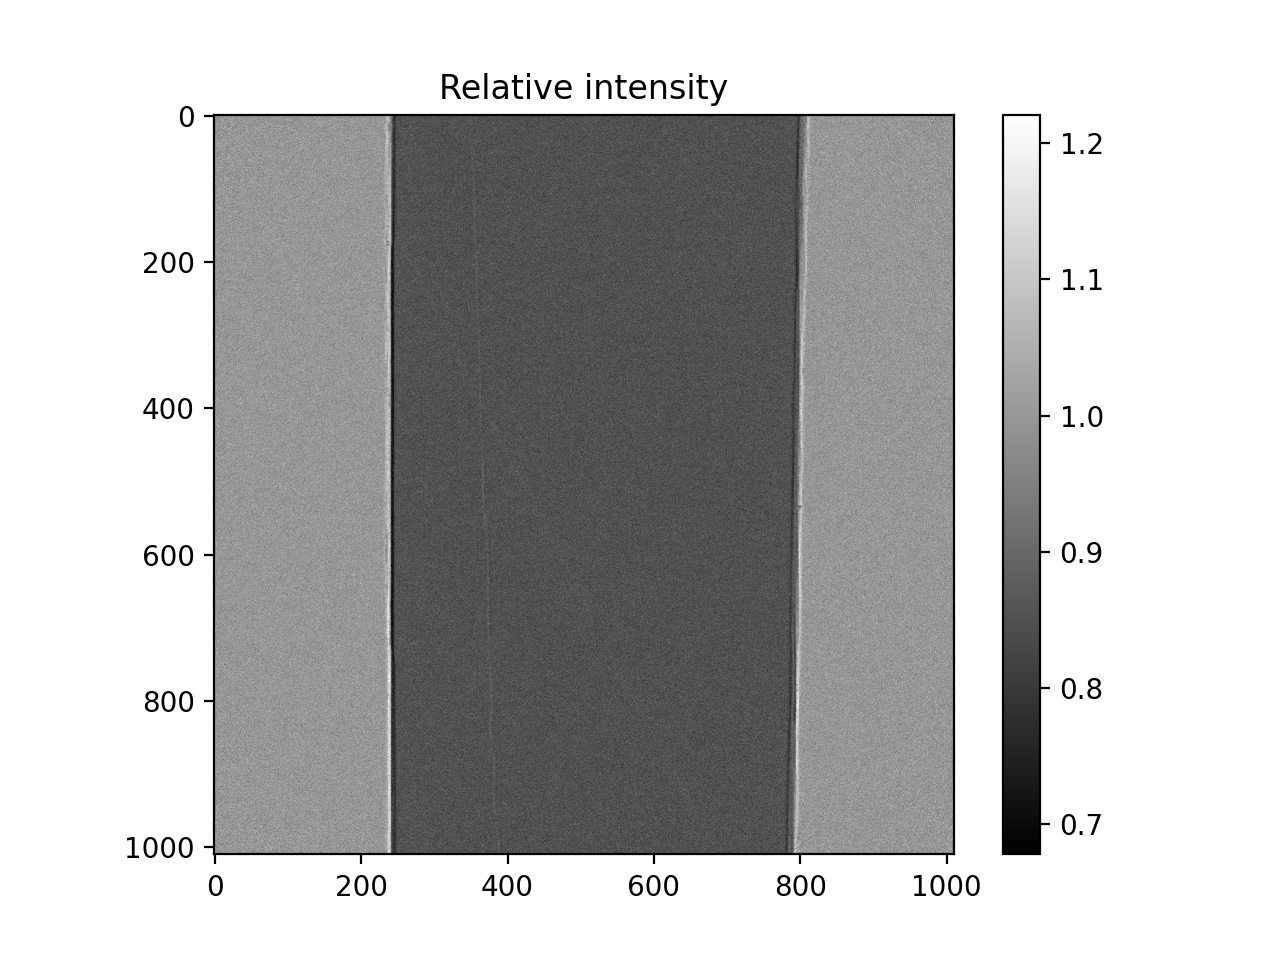

In [3]:
plt.figure()
plt.title('Relative intensity')
plt.imshow(proj)
plt.colorbar()

Plot a horizontal line profile of the object near the center of the image and an averaged line profile over all rows.

<IPython.core.display.Javascript object>


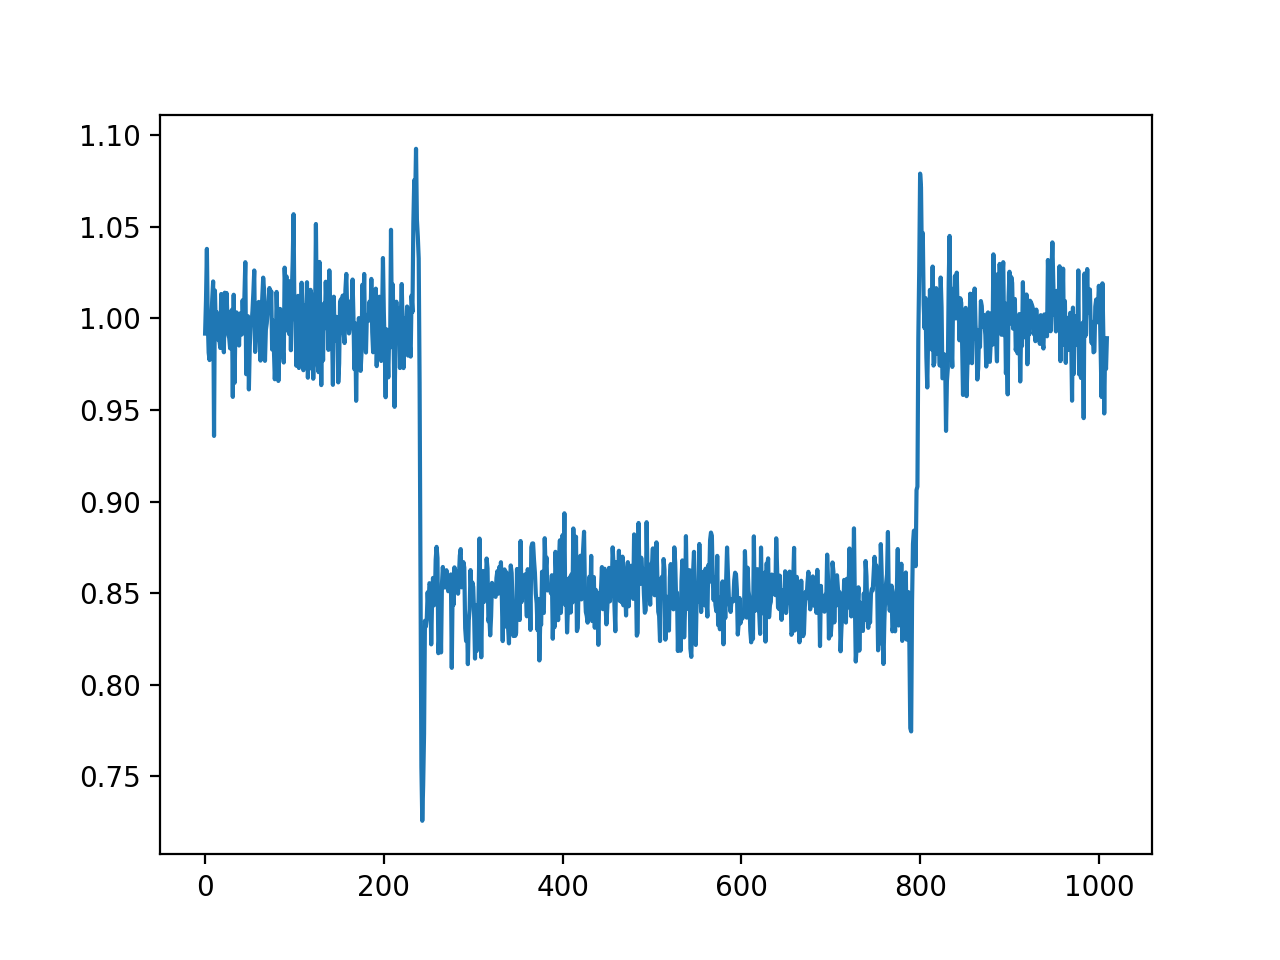

In [4]:
plt.figure()
plt.plot(proj[proj.shape[0]//2, :]) #select mid-row, all columns
#plt.plot(np.mean(proj, 0))#mean over all rows

<IPython.core.display.Javascript object>


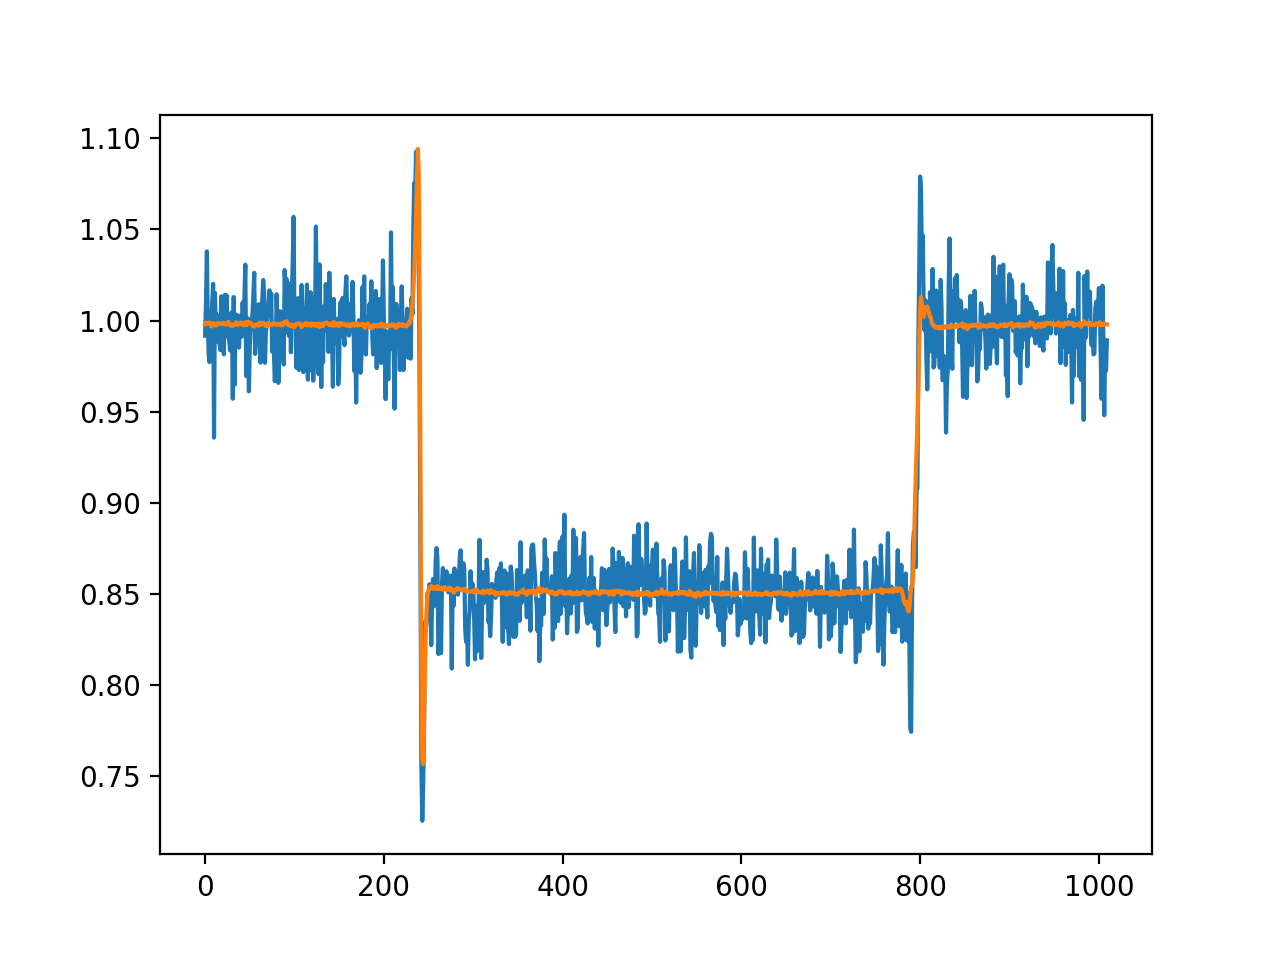

In [6]:
plt.figure()
plt.plot(proj[proj.shape[0]//2, :]) #select mid-row, all columns
plt.plot(np.mean(proj, 0))#mean over all rows

overshoot in the transition areas

The parameters of the setup that influence the image formation process are specified below.
* ``pixel_size`` is the edge length of a single pixel of the used X-ray detector.
* ``distance`` is the distance between the imaged sample and the detector.

Both quantities are given in meters.

In [8]:
np.mean?

In [9]:
pixel_size = .964e-6  # m
distance = 8.57e-3    # m

Paganin's algorithm assumes that the imaged object consists of a single material 
with a known ratio of the real and imaginary components of the index of refraction.
For X-ray energies, a material's index of refraction is typically written as

$$ n = 1 - \delta + i \beta .$$

We thus look up $\delta$ and $\beta$ in a database. Instead of $\beta$ however, we use
the linear attenuation coefficient $\mu=4 \pi \beta / \lambda$, with $\lambda$ the
wavelength of the X-rays.

See for example: http://purple.ipmt-hpm.ac.ru/xcalc/xcalc_mysql/ref_index.php.
The chemical formula for Teflon is (C<sub>2</sub>F<sub>4</sub>)<sub>n</sub>.

Note that $\delta$ and $\beta$ depend on photon energy (dispersion!) and the used values must match
the X-ray wavelength used in the experiment!

In [10]:
mu = 691.
delta = 2.6e-6

The spatial frequencies / wavenumbers $\vec{k}_\perp$=``(kx,ky)``
that correspond to the different parts of the Fourier image
are provided for you according to our conventions:

In [11]:
v = 2. * np.pi * np.fft.fftfreq(proj.shape[0], d=pixel_size)
u = 2. * np.pi * np.fft.fftfreq(proj.shape[1], d=pixel_size)
ky, kx = np.meshgrid(v, u, indexing='ij')

Build the Paganin kernel. Its representation was discussed in the lecture.

In [14]:
paganin = 1. / (distance * delta / mu * (kx**2 + ky**2) + 1) #defined in Fourier space

Recover the thickness from the projection by applying the Paganin kernel onto
the intensity measurement. The result is given in meters.

In [15]:
#thickness_map = -1./mu*np.log(np.fft.ifft2(paganin*np.fft.fft2(proj).real))
thickness_map = -np.log(np.fft.ifft2(np.fft.fft2(proj) * paganin).real) / mu

Plot the recovered thickness of the sample in microns.
Also plot a line through the center row of the trace.

Check if the retrieved thickness matches the stated
thickness in the beginning of our exercise.

<IPython.core.display.Javascript object>


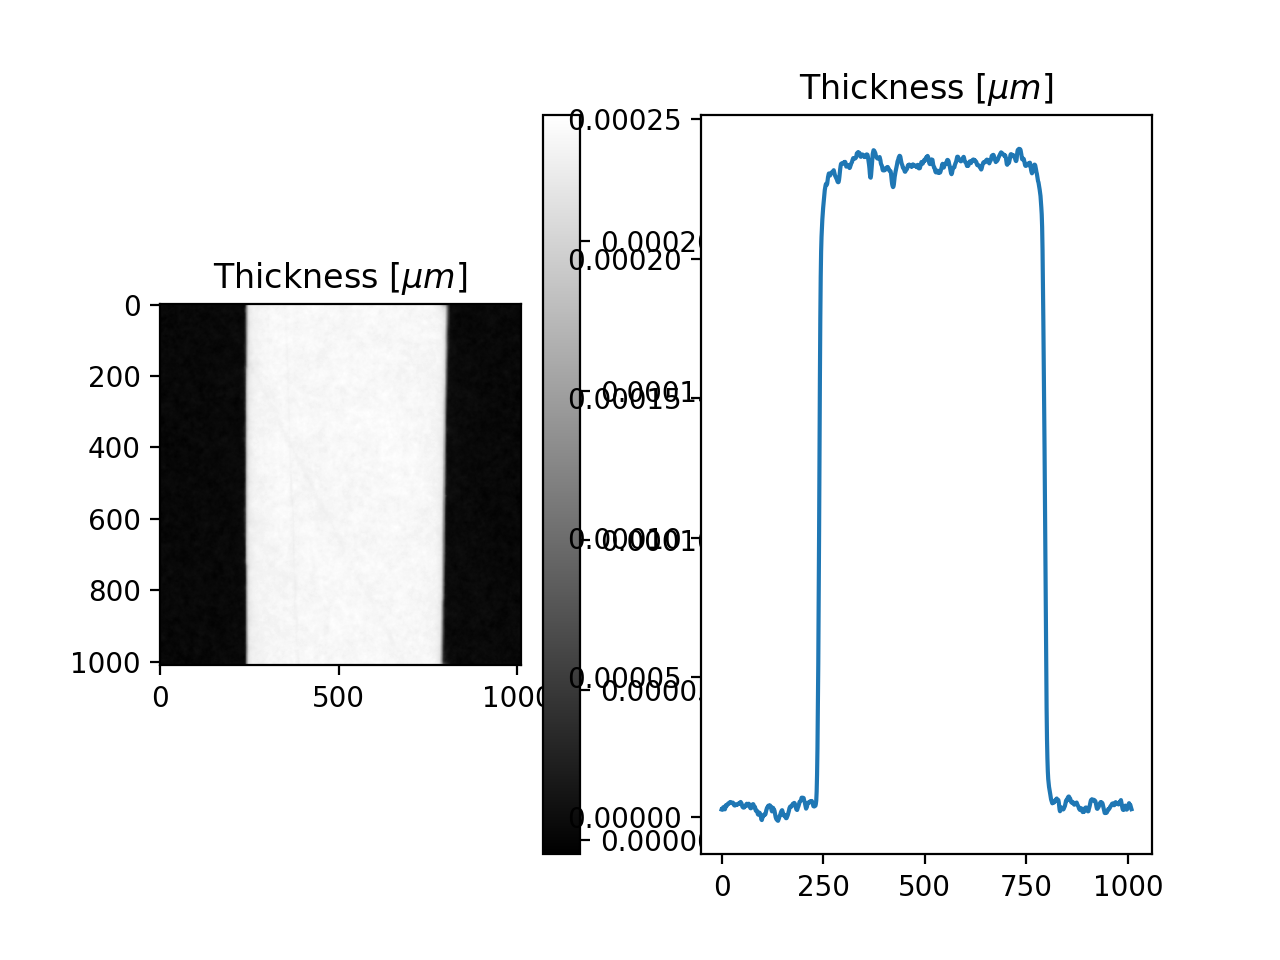

In [16]:
plt.figure()
plt.subplot(121)
plt.title(r'Thickness [$\mu m$]')
plt.imshow(thickness_map)
plt.colorbar()
plt.subplot(122)
plt.title(r'Thickness [$\mu m$]')
plt.plot(thickness_map[thickness_map.shape[0]//2, :])

The line plot is less noisy than the original. This is due to the fact that Paganin is a low pass filter -> the larger the frequencies **k** , the smaller weights the kernel assigns. Another advantage is that the resolution is not affected by removing the high frequencies with this filter . While we supress the noise in the sampled information, we only removed the boosted noise part. 